Traceback (most recent call last):
  File "C:\Users\1\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\1\anaconda3\lib\site-packages\matplotlib\backends\backend_nbagg.py", line 236, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "C:\Users\1\anaconda3\lib\site-packages\matplotlib\_pylab_helpers.py", line 53, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


Initial Portfolio Value : 1,000,000 KRW
Final Portfolio Value : 1,000,000 KRW


<IPython.core.display.Javascript object>


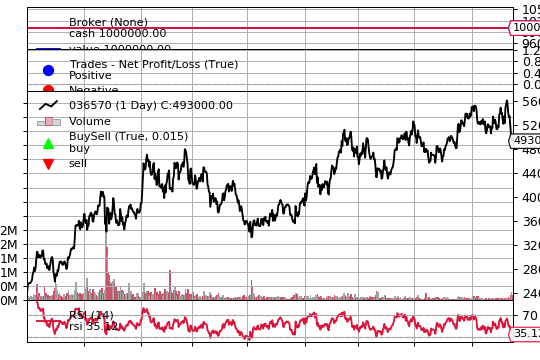

[[<Figure size 432x288 with 5 Axes>]]

In [2]:
# 장고는 파이썬 기반 웹 프레임워크로 백엔드 개발에 사용(프론트엔드-사용자에게 보이는 부분, 백엔드-안보이는 부분)
# 또다른 파이썬기반 웹프레임워크로는 플라스크 존재, 장고가 대규모 웹사이트 목적으로 다양한 패키지를 제공하기 때문에 초보자에게 적합 ; 플라스크는 패키지가 부족한 대신 자유도가 높음 + 마이크로프레임 목적
# !pip install django선행

#django-admin starproject Investar 로 Investar 디렉토리 생성 -> cd Investar -> python manage.py runserver 0.0.0.0:8000 으로 서버설치 -> 서버가 정상적으로 구동되었다면 http://localhost:8000에 접속 시 설치 성공페이지가 뜸
#이외 장고 관련된 내용은 책&mySite폴더 참고

#백트레이더를 활용한 백테스트
#백테스트 소프트웨어 백트레이더(Backtrader)사용 ; pip install backtrader 선행 ; 백트레이더 홈페이지는 www.backtrader.com

#엔씨소프트 주식을 상대적 강도지수를 이용해서 매매했을 떄 수익률 확인 ; RSI는 움직임의 강도를 백분율로 나타내며100 - 100/(1+RS), RS = N일간의 상승폭평균/N일간의 하락폭평균
#일반적으로 RSI가 70이사일 땐 과매수(매도시점), 30이하면 과매도(매수시점)

#백트레이더 라이브러리를 이용, 엔씨소프트 종가정보를 취합한 뒤 천만원의 초기투자금액으로 RSI 지표에 따라 매매했을 때 백테스트 결과 출력
from datetime import datetime
import backtrader as bt
%matplotlib inline

class MyStrategy(bt.Strategy): #bt.Strategy 클래스 상속받아서 MyStrategy 클래스 작성
    def __init__(self):
        self.rsi = bt.indicators.RSI(self.data.close) #RSI 지표로 사용할 변수 지정
    def next(self): #RSI가 30미만이면 매수, 70이상이면 매도하도록 구현
        if not self.position: 
            if self.rsi < 30:
                self.order = self.buy()
        else:
            if self.rsi > 70:
                self.order = self.sell()


cerebro = bt.Cerebro() # Cerebro 클래스는 백테스트, 라이브 트레이딩 등을 실행 후 결과를 출력하는 핵심 클래시
cerebro.addstrategy(MyStrategy)
data = bt.feeds.YahooFinanceData(dataname = '036570.KS', fromdate = datetime(2017,1,1), todate=datetime(2019,12,1)) #엔씨소프트 종가데이터를 야후파이낸스에서 취합
cerebro.adddata(data)
cerebro.broker.setcash(1000000)
cerebro.addsizer(bt.sizers.SizerFix, stake=30) #매매단위를 30주로 설정

print(f"Initial Portfolio Value : {cerebro.broker.getvalue():,.0f} KRW")
cerebro.run() #백테스트 실행
print(f"Final Portfolio Value : {cerebro.broker.getvalue():,.0f} KRW")
cerebro.plot() #차트출력

#FileNotFoundError -> backtrader\feeds\yahoo.py 파일의 333라인 수정 : if 'text/csv' not in ctype: -> if ctype not in ['text/csv', 'text/plain']:

In [13]:
#RSI_SMA(커틀러 RSI)를 이용한 백테스트 - 상승분과 하락분을 계산할 때 RSI대신 이평선 이용
import backtrader as bt
from datetime import datetime

class MyStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order=None
        self.buyprice=None
        self.buycom=None
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21) #bt.indicators 패키지는 DMA, EMA, MACD, SMA, Stochastic, WMA, CCI, Bollinger 등 대부분의 지표 제공
        
        def notify_order(self, order): #주문 상태에 변화가 있을 때마다 자동 실행
            if order.status in [order.Submitted, order.Accepted]:
                return
            if order.status in [order.Completed]: #주문상태가 완료이면 매수인지 매도인지 확인하여 상세정보 출력
                if order.isbuy():
                    self.log(f"BUY : 주가 {order.executed.price:,.0f}, 수량 {order.executed.size:,.0f}, 수수료 {order.executed.comm:,.0f:}, 자산{cerebro.broker.getvalue():,.0f}")
                    self.buyprice = order.executed.price
                    self.buycom = order.executed.comm
                else:
                    self.log(f"SELL : 주가 {order.executed.price:,.0f}, 수량 {order.executed.size:,.0f}, 수수료 {order.executed.comm:,.0f:}, 자산{cerebro.broker.getvalue():,.0f}")
                    self.bar_executed = len(self)
            elif order.status in [order.Canceled]:
                    self.log("ORDER CANCELED")
            elif order.status in [order.Margin]:
                self.log("ORDER MARGIN")
            elif order.status in [order.Rejected]:
                self.log("ORDER REJECTED")
            self.order = None
        
        def next(self):
            if not self.position: 
                if self.rsi < 30:
                    self.order = self.buy()
            else:
                if self.rsi > 70:
                    self.order = self.sell()
        
        def log(self, txt, dt=None): #텍스트 메세지를 인수로 받아 셸 화면에 주문일자와 함께 출력
            dt = self.datas[0].datetime.date(0)
            print(f"[{dt.isoformat()}] {txt}")

cerebro = bt.Cerebro() # Cerebro 클래스는 백테스트, 라이브 트레이딩 등을 실행 후 결과를 출력하는 핵심 클래시
cerebro.addstrategy(MyStrategy)
data = bt.feeds.YahooFinanceData(dataname = '036570.KS', fromdate = datetime(2017,1,1), todate=datetime(2019,12,1)) #엔씨소프트 종가데이터를 야후파이낸스에서 취합
cerebro.adddata(data)
cerebro.broker.setcash(1000000)
cerebro.broker.setcommission(commission=0.0014) #수수료 , 일반적으로 증권거래세 0.25% + 0.015% 증권수수료 -> 백트레이더에서는 매수/매도시점마다 수수료가 두번 차감되므로 2로 나눠 0.014%
cerebro.addsizer(bt.sizers.PercentSizer, percents=90) #size는 매매주문을 적용할 주식수, 기본값 1 ; PercentSizer를 이용하면 포트폴리오 자산에 대한 퍼센트로 지정가능, 수수료를 차감한 퍼센트로 지정

print(f"Initial Portfolio Value : {cerebro.broker.getvalue():,.0f} KRW")
cerebro.run() #백테스트 실행
print(f"Final Portfolio Value : {cerebro.broker.getvalue():,.0f} KRW")
cerebro.plot(style = 'candlestick') #차트출력

Initial Portfolio Value : 1,000,000 KRW


FileNotFoundError: [Errno 2] No such file or directory: '036570.KS'